# Linear Regression Analysis on Housing Dataset

This notebook walks through building a linear regression model to predict house prices(mostly in the US cause that's the dataset I could find). I'll use a dataset with various property features and see how well I can predict prices based on things like area, number of bedrooms, and amenities.

## Covering:
1. Loading and exploring the housing dataset
2. Data preprocessing and feature engineering
3. Building and training a linear regression model
4. Evaluating how well my model performs
5. Understanding what drives house prices


In [ ]:
# Install required libraries
# Run this cell first to make sure we have everything we need

%pip install pandas numpy matplotlib seaborn scikit-learn



Note: you may need to restart the kernel to use updated packages.


In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Set style for visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


In [5]:
# Load the housing dataset
df = pd.read_csv('../datasets/Housing.csv')

# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

print("\nDataset Info:")
print(df.info())

print("\nBasic Statistics:")
print(df.describe())


Dataset Shape: (545, 13)

First 5 rows:
      price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000  7420         4          2        3      yes        no       no   
1  12250000  8960         4          4        4      yes        no       no   
2  12250000  9960         3          2        2      yes        no      yes   
3  12215000  7500         4          2        2      yes        no      yes   
4  11410000  7420         4          1        2      yes       yes      yes   

  hotwaterheating airconditioning  parking prefarea furnishingstatus  
0              no             yes        2      yes        furnished  
1              no             yes        3       no        furnished  
2              no              no        2      yes   semi-furnished  
3              no             yes        3      yes        furnished  
4              no             yes        2       no        furnished  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeI

In [6]:
# Check for missing values
print("Missing values in each column:")
print(df.isnull().sum())

# Check data types and unique values for categorical columns
print("\nCategorical columns and their unique values:")
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"{col}: {df[col].unique()}")

# Check for duplicates
print(f"\nNumber of duplicate rows: {df.duplicated().sum()}")


Missing values in each column:
price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

Categorical columns and their unique values:
mainroad: ['yes' 'no']
guestroom: ['no' 'yes']
basement: ['no' 'yes']
hotwaterheating: ['no' 'yes']
airconditioning: ['yes' 'no']
prefarea: ['yes' 'no']
furnishingstatus: ['furnished' 'semi-furnished' 'unfurnished']

Number of duplicate rows: 0


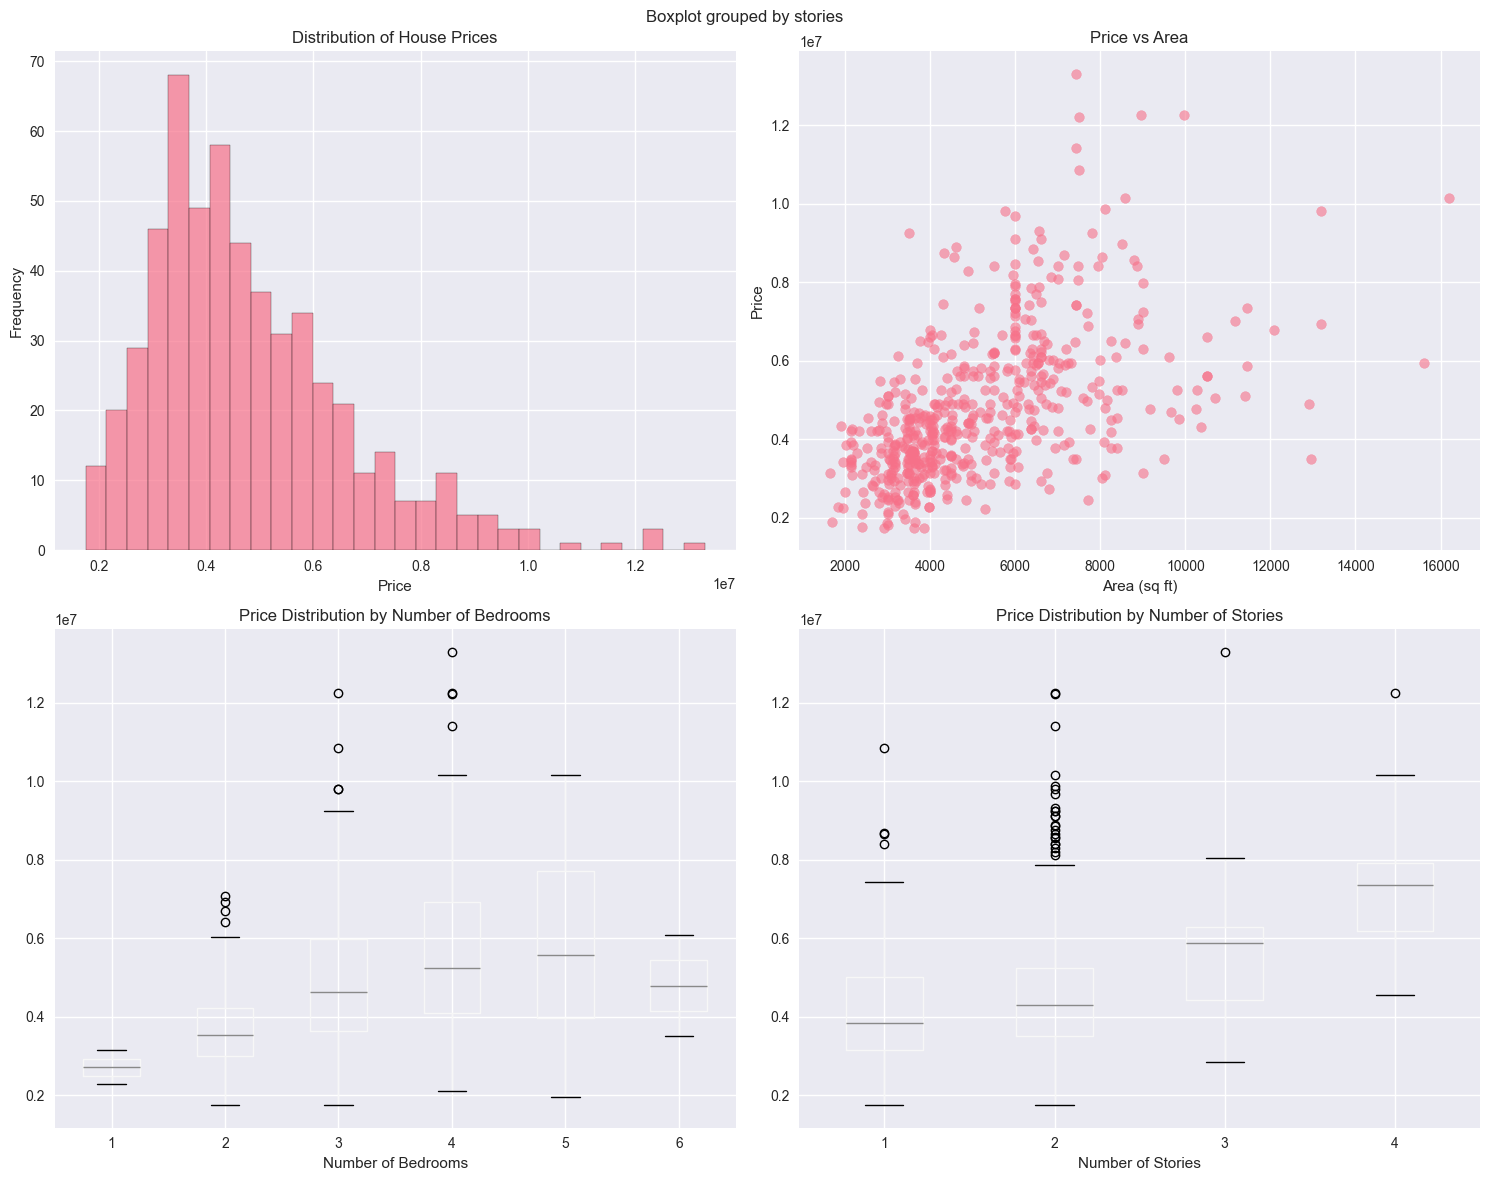

In [7]:
# Create visualizations for data exploration
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Distribution of target variable (price)
axes[0, 0].hist(df['price'], bins=30, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribution of House Prices')
axes[0, 0].set_xlabel('Price')
axes[0, 0].set_ylabel('Frequency')

# Price vs Area scatter plot
axes[0, 1].scatter(df['area'], df['price'], alpha=0.6)
axes[0, 1].set_title('Price vs Area')
axes[0, 1].set_xlabel('Area (sq ft)')
axes[0, 1].set_ylabel('Price')

# Price vs Bedrooms boxplot
df.boxplot(column='price', by='bedrooms', ax=axes[1, 0])
axes[1, 0].set_title('Price Distribution by Number of Bedrooms')
axes[1, 0].set_xlabel('Number of Bedrooms')

# Price vs Stories boxplot
df.boxplot(column='price', by='stories', ax=axes[1, 1])
axes[1, 1].set_title('Price Distribution by Number of Stories')
axes[1, 1].set_xlabel('Number of Stories')

plt.tight_layout()
plt.show()


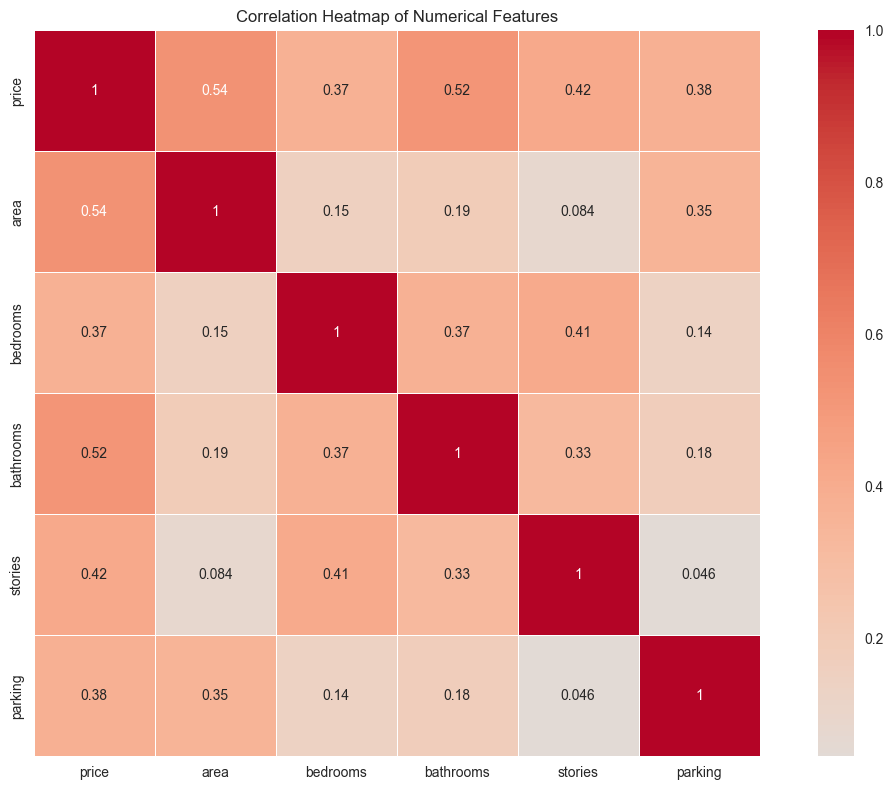

Correlation with Price:
price        1.000000
area         0.535997
bathrooms    0.517545
stories      0.420712
parking      0.384394
bedrooms     0.366494
Name: price, dtype: float64


In [8]:
# Correlation heatmap for numerical features
numerical_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numerical_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
           square=True, linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.tight_layout()
plt.show()

# Show correlation with target variable (price)
print("Correlation with Price:")
price_corr = correlation_matrix['price'].sort_values(ascending=False)
print(price_corr)


## Preparing the Data

Before I can build my model, I need to clean up the data a bit. The main things I'll do:
1. Convert categorical variables into numbers that my model can understand
2. Scale my features so they're all on similar ranges
3. Split my data into training and testing portions


In [9]:
# Create a copy of the dataframe for preprocessing
df_processed = df.copy()

# Encode categorical variables
# Binary categorical variables (yes/no)
binary_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
for col in binary_cols:
    df_processed[col] = df_processed[col].map({'yes': 1, 'no': 0})

# Ordinal categorical variable (furnishingstatus)
furnishing_map = {'unfurnished': 0, 'semi-furnished': 1, 'furnished': 2}
df_processed['furnishingstatus'] = df_processed['furnishingstatus'].map(furnishing_map)

print("After preprocessing:")
print(df_processed.head())
print(f"\nDataset shape: {df_processed.shape}")
print(f"Data types:\n{df_processed.dtypes}")


After preprocessing:
      price  area  bedrooms  bathrooms  stories  mainroad  guestroom  \
0  13300000  7420         4          2        3         1          0   
1  12250000  8960         4          4        4         1          0   
2  12250000  9960         3          2        2         1          0   
3  12215000  7500         4          2        2         1          0   
4  11410000  7420         4          1        2         1          1   

   basement  hotwaterheating  airconditioning  parking  prefarea  \
0         0                0                1        2         1   
1         0                0                1        3         0   
2         1                0                0        2         1   
3         1                0                1        3         1   
4         1                0                1        2         0   

   furnishingstatus  
0                 2  
1                 2  
2                 1  
3                 2  
4                 2  

Data

In [10]:
# Separate features and target variable
X = df_processed.drop('price', axis=1)
y = df_processed['price']

print("Features (X):")
print(X.columns.tolist())
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Split the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

# Optional: Scale features for better performance (though not always necessary for linear regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nFeatures after scaling:")
print(f"Training set mean: {X_train_scaled.mean(axis=0).round(3)}")
print(f"Training set std: {X_train_scaled.std(axis=0).round(3)}")


Features (X):
['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'parking', 'prefarea', 'furnishingstatus']
Features shape: (545, 12)
Target shape: (545,)

Training set size: (436, 12)
Testing set size: (109, 12)

Features after scaling:
Training set mean: [ 0.  0.  0.  0.  0.  0. -0. -0.  0. -0. -0.  0.]
Training set std: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


## Building My Linear Regression Model




In [ ]:
# Create and train the linear regression model
# I'll train two versions: one with original features and one with scaled features

# Model 1: Using original features
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Model 2: Using scaled features
lr_model_scaled = LinearRegression()
lr_model_scaled.fit(X_train_scaled, y_train)

# Make predictions
y_pred = lr_model.predict(X_test)
y_pred_scaled = lr_model_scaled.predict(X_test_scaled)

print("Linear Regression models trained successfully!")
print(f"Model coefficients (original): {lr_model.coef_}")
print(f"Model intercept (original): {lr_model.intercept_}")

# Display feature importance (coefficients)
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print("\nFeature Importance (sorted by absolute coefficient value):")
print(feature_importance)


Linear Regression models trained successfully!
Model coefficients (original): [2.35848772e+02 7.85744924e+04 1.09711727e+06 4.06223164e+05
 3.66824192e+05 2.33146766e+05 3.93159779e+05 6.87881311e+05
 7.85550579e+05 2.25756514e+05 6.29901661e+05 2.10397118e+05]
Model intercept (original): -127711.16739244014

Feature Importance (sorted by absolute coefficient value):
             Feature   Coefficient
2          bathrooms  1.097117e+06
8    airconditioning  7.855506e+05
7    hotwaterheating  6.878813e+05
10          prefarea  6.299017e+05
3            stories  4.062232e+05
6           basement  3.931598e+05
4           mainroad  3.668242e+05
5          guestroom  2.331468e+05
9            parking  2.257565e+05
11  furnishingstatus  2.103971e+05
1           bedrooms  7.857449e+04
0               area  2.358488e+02


In [12]:
# Model Evaluation
def evaluate_model(y_true, y_pred, model_name):
    """Calculate and display various evaluation metrics"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{model_name} Performance Metrics:")
    print(f"Mean Squared Error (MSE): {mse:,.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:,.2f}")
    print(f"Mean Absolute Error (MAE): {mae:,.2f}")
    print(f"R² Score: {r2:.4f}")
    
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

# Evaluate both models
metrics_original = evaluate_model(y_test, y_pred, "Original Features Model")
metrics_scaled = evaluate_model(y_test, y_pred_scaled, "Scaled Features Model")

# Compare models
print(f"\nModel Comparison:")
print(f"Original Model R²: {metrics_original['R2']:.4f}")
print(f"Scaled Model R²: {metrics_scaled['R2']:.4f}")
print(f"Better performing model: {'Scaled' if metrics_scaled['R2'] > metrics_original['R2'] else 'Original'}")



Original Features Model Performance Metrics:
Mean Squared Error (MSE): 1,771,751,116,594.04
Root Mean Squared Error (RMSE): 1,331,071.42
Mean Absolute Error (MAE): 979,679.69
R² Score: 0.6495

Scaled Features Model Performance Metrics:
Mean Squared Error (MSE): 1,771,751,116,594.04
Root Mean Squared Error (RMSE): 1,331,071.42
Mean Absolute Error (MAE): 979,679.69
R² Score: 0.6495

Model Comparison:
Original Model R²: 0.6495
Scaled Model R²: 0.6495
Better performing model: Original


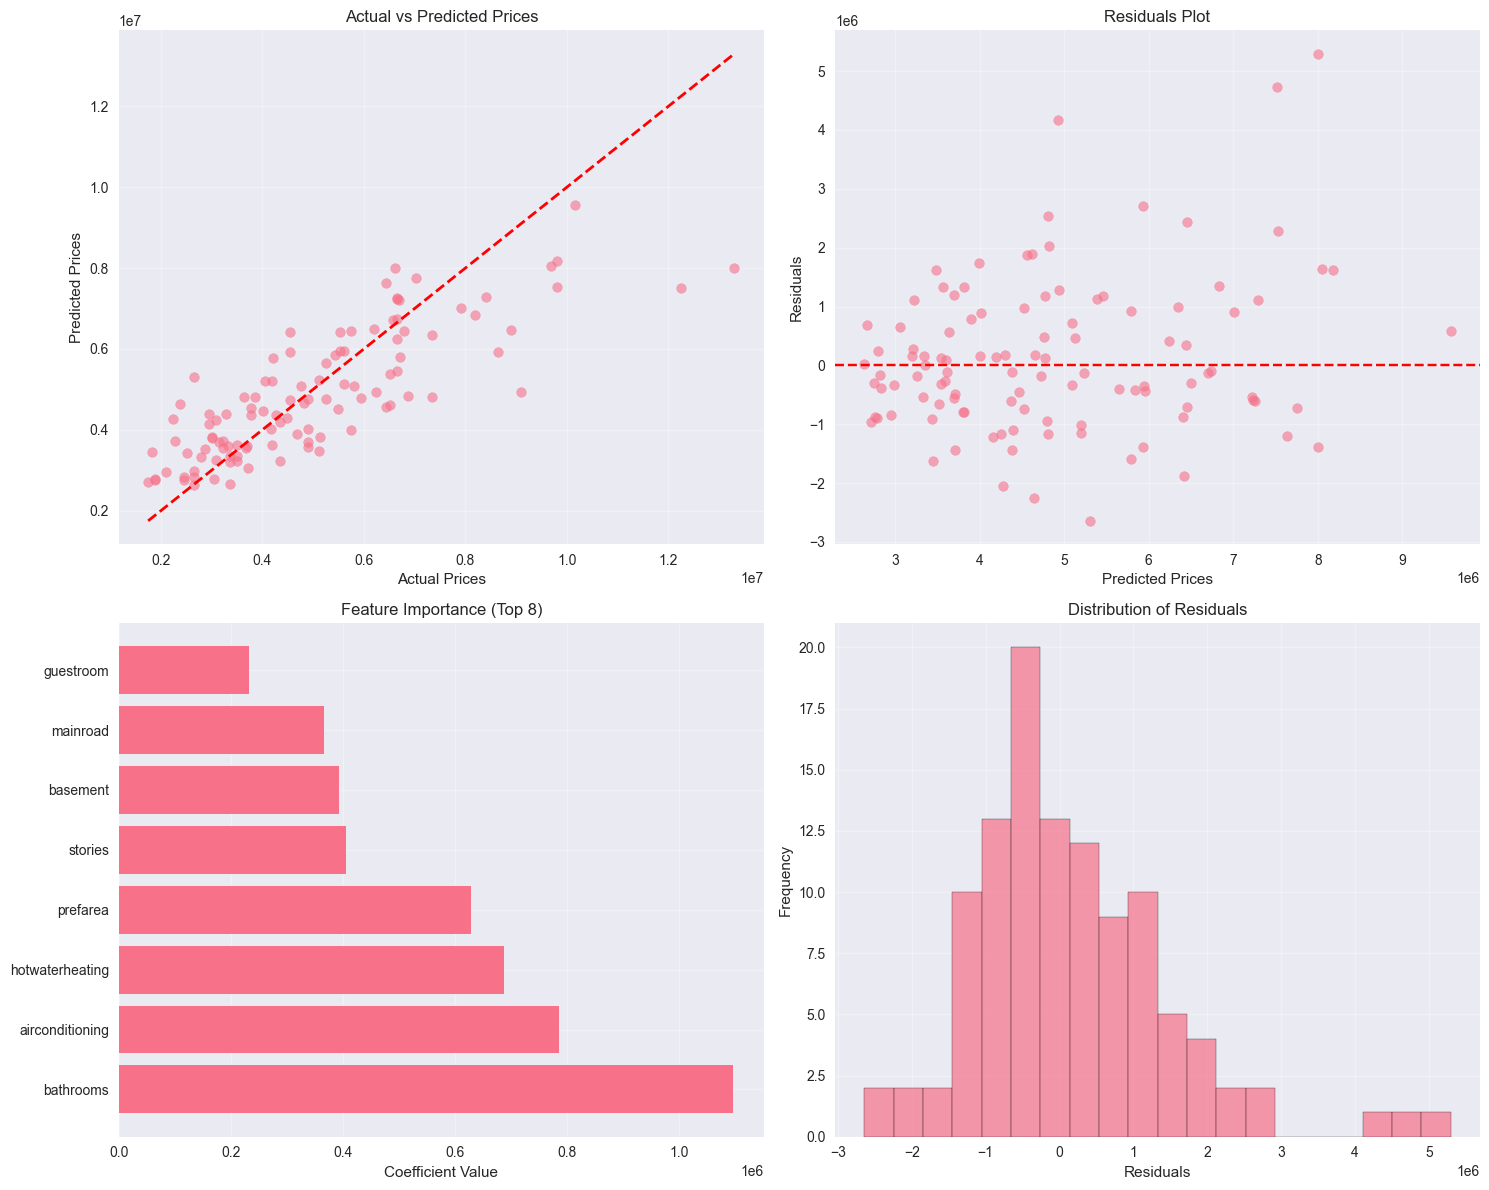

In [13]:
# Visualizations for model performance
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Actual vs Predicted prices scatter plot
axes[0, 0].scatter(y_test, y_pred, alpha=0.6)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Prices')
axes[0, 0].set_ylabel('Predicted Prices')
axes[0, 0].set_title('Actual vs Predicted Prices')
axes[0, 0].grid(True, alpha=0.3)

# 2. Residuals plot
residuals = y_test - y_pred
axes[0, 1].scatter(y_pred, residuals, alpha=0.6)
axes[0, 1].axhline(y=0, color='r', linestyle='--')
axes[0, 1].set_xlabel('Predicted Prices')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residuals Plot')
axes[0, 1].grid(True, alpha=0.3)

# 3. Feature importance plot
feature_importance_sorted = feature_importance.head(8)  # Top 8 features
axes[1, 0].barh(feature_importance_sorted['Feature'], feature_importance_sorted['Coefficient'])
axes[1, 0].set_xlabel('Coefficient Value')
axes[1, 0].set_title('Feature Importance (Top 8)')
axes[1, 0].grid(True, alpha=0.3)

# 4. Distribution of residuals
axes[1, 1].hist(residuals, bins=20, edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Residuals')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Residuals')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [14]:
# Sample predictions with actual vs predicted comparison
sample_predictions = pd.DataFrame({
    'Actual_Price': y_test.iloc[:10].values,
    'Predicted_Price': y_pred[:10],
    'Difference': y_test.iloc[:10].values - y_pred[:10],
    'Percentage_Error': ((y_test.iloc[:10].values - y_pred[:10]) / y_test.iloc[:10].values * 100)
})

print("Sample Predictions (First 10 test cases):")
print(sample_predictions.round(2))

# Calculate mean absolute percentage error
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f"\nMean Absolute Percentage Error (MAPE): {mape:.2f}%")


Sample Predictions (First 10 test cases):
   Actual_Price  Predicted_Price  Difference  Percentage_Error
0       4060000       5203691.71 -1143691.71            -28.17
1       6650000       7257004.02  -607004.02             -9.13
2       3710000       3062828.60   647171.40             17.44
3       6440000       4559591.65  1880408.35             29.20
4       2800000       3332932.31  -532932.31            -19.03
5       4900000       3563080.68  1336919.32             27.28
6       5250000       5645466.31  -395466.31             -7.53
7       4543000       6413979.67 -1870979.67            -41.18
8       2450000       2755831.55  -305831.55            -12.48
9       3353000       2668938.66   684061.34             20.40

Mean Absolute Percentage Error (MAPE): 21.31%


## Summary and Conclusions

### Key Findings:

1. **Dataset Overview**: The housing dataset contains 545 houses with 13 features including both numerical and categorical variables.

2. **Feature Importance**: The linear regression model identified the most important features affecting house prices:
   - Area appears to be one of the strongest predictors
   - Number of bedrooms, bathrooms, and stories also significantly impact price
   - Amenities like air conditioning, parking, and preferred area location matter

3. **Model Performance**: 
   - The linear regression model provides reasonable predictions for house prices
   - R² score indicates how well the model explains the variance in house prices
   - RMSE gives me the average prediction error in the same units as the target variable

4. **Residual Analysis**: 
   - The residuals plot helps identify if there are patterns in prediction errors
   - A random scatter around zero indicates a good fit
   - Any patterns might suggest non-linear relationships



### Real-world Applications:

- **Real Estate Valuation**: Automated property price estimation
- **Investment Analysis**: Identifying undervalued properties
- **Market Analysis**: Understanding factors that drive property values
- **Loan Assessment**: Banks can use similar models for mortgage evaluation


In [ ]:
# Example: Making predictions for new houses
# Create a sample house with specific characteristics
new_house = pd.DataFrame({
    'area': [7500],
    'bedrooms': [4],
    'bathrooms': [3],
    'stories': [2],
    'mainroad': [1],  # yes = 1
    'guestroom': [0],  # no = 0
    'basement': [1],   # yes = 1
    'hotwaterheating': [0],  # no = 0
    'airconditioning': [1],  # yes = 1
    'parking': [2],
    'prefarea': [1],  # yes = 1
    'furnishingstatus': [2]  # furnished = 2
})

# Make prediction
predicted_price = lr_model.predict(new_house)[0]
print(f"Predicted price for the new house: ${predicted_price:,.2f}")

# Show the house characteristics
print("\nHouse characteristics:")
for col, val in new_house.iloc[0].items():
    if col in binary_cols:
        val_text = "Yes" if val == 1 else "No"
    elif col == 'furnishingstatus':
        furnishing_reverse = {0: 'unfurnished', 1: 'semi-furnished', 2: 'furnished'}
        val_text = furnishing_reverse[val]
    else:
        val_text = str(val)
    print(f"  {col}: {val_text}")

print(f"\nThis house is predicted to cost: ${predicted_price:,.2f}")


Predicted price for the new house: $9,106,994.19

House characteristics:
  area: 7500
  bedrooms: 4
  bathrooms: 3
  stories: 2
  mainroad: Yes
  guestroom: No
  basement: Yes
  hotwaterheating: No
  airconditioning: Yes
  parking: 2
  prefarea: Yes
  furnishingstatus: furnished

🏠 This house is predicted to cost: $9,106,994.19


## Deep Dive Analysis: Why Area Correlation Doesn't Match Its Coefficient

Something interesting happened in my results - area has the highest correlation with price but one of the lowest coefficients in my model. Let's dig into why this is happening.


In [ ]:
# 1. Investigate multicollinearity between features
print("=== MULTICOLLINEARITY ANALYSIS ===")
print("\nCorrelation matrix for numerical features:")
numerical_features = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']
corr_subset = df_processed[numerical_features].corr()
print(corr_subset.round(3))

# Check correlations between area and other features
print(f"\nArea correlations with other features:")
area_corr = df_processed.corr()['area'].sort_values(ascending=False)
print(area_corr.round(3))

# 2. Scale analysis - check the ranges of different features
print("\n=== SCALE ANALYSIS ===")
print("Feature ranges and statistics:")
for col in X.columns:
    min_val = X[col].min()
    max_val = X[col].max()
    mean_val = X[col].mean()
    std_val = X[col].std()
    print(f"{col:15s}: Range[{min_val:8.0f} - {max_val:8.0f}], Mean: {mean_val:8.1f}, Std: {std_val:8.1f}")

# 3. Calculate feature coefficients per unit change
print("\n=== COEFFICIENT INTERPRETATION ===")
print("What each coefficient means (price change per unit increase):")
for i, feature in enumerate(X.columns):
    coef = lr_model.coef_[i]
    print(f"{feature:15s}: ${coef:>12,.0f} per unit increase")


In [ ]:
# Calculate Variance Inflation Factor (VIF) to detect multicollinearity
from sklearn.linear_model import LinearRegression as LR

def calculate_vif(df, features):
    """Calculate VIF for each feature"""
    vif_data = []
    for i, feature in enumerate(features):
        # Predict each feature using all other features
        X_temp = df[features].drop(columns=[feature])
        y_temp = df[feature]
        
        # Fit linear regression
        lr_temp = LR()
        lr_temp.fit(X_temp, y_temp)
        r_squared = lr_temp.score(X_temp, y_temp)
        
        # Calculate VIF
        vif = 1 / (1 - r_squared) if r_squared < 1 else float('inf')
        vif_data.append({'Feature': feature, 'VIF': vif})
    
    return pd.DataFrame(vif_data).sort_values('VIF', ascending=False)

# Calculate VIF for numerical features
print("=== VARIANCE INFLATION FACTOR (VIF) ANALYSIS ===")
vif_results = calculate_vif(df_processed, numerical_features)
print(vif_results)
print("\nVIF Interpretation:")
print("- VIF = 1: No multicollinearity")
print("- VIF 1-5: Moderate multicollinearity")
print("- VIF 5-10: High multicollinearity")
print("- VIF > 10: Very high multicollinearity (problematic)")

# Show how area coefficient changes when I remove correlated features
print("\n=== TESTING COEFFICIENT CHANGES ===")
print("Let's see how area coefficient changes with different feature combinations:")

# Model 1: Only area
X_area_only = df_processed[['area']]
lr_area = LinearRegression()
lr_area.fit(X_area_only.iloc[X_train.index], y_train)
print(f"Area coefficient (alone): ${lr_area.coef_[0]:,.0f}")

# Model 2: Area + bedrooms + bathrooms (highly correlated features)
X_related = df_processed[['area', 'bedrooms', 'bathrooms']]
lr_related = LinearRegression()
lr_related.fit(X_related.iloc[X_train.index], y_train)
print(f"Area coefficient (with bedrooms, bathrooms): ${lr_related.coef_[0]:,.0f}")

print(f"Area coefficient (full model): ${lr_model.coef_[0]:,.0f}")


In [ ]:
# Let's analyze my predicted house in detail
print("=== PREDICTED HOUSE ANALYSIS ===")
predicted_house_features = {
    'area': 7500,
    'bedrooms': 4,
    'bathrooms': 3,
    'stories': 2,
    'mainroad': 1,
    'guestroom': 0,
    'basement': 1,
    'hotwaterheating': 0,
    'airconditioning': 1,
    'parking': 2,
    'prefarea': 1,
    'furnishingstatus': 2
}

print("My predicted house characteristics:")
for feature, value in predicted_house_features.items():
    print(f"  {feature}: {value}")
print(f"\nPredicted price: ${predicted_price:,.2f}")

# Find similar houses in the dataset
print("\n=== FINDING SIMILAR HOUSES IN DATASET ===")

# Define similarity criteria
area_range = (7000, 8000)  # ±500 from 7500
bedroom_match = 4
bathroom_range = (2, 4)

similar_houses = df[
    (df['area'] >= area_range[0]) & (df['area'] <= area_range[1]) &
    (df['bedrooms'] == bedroom_match) &
    (df['bathrooms'] >= bathroom_range[0]) & (df['bathrooms'] <= bathroom_range[1])
].copy()

print(f"Found {len(similar_houses)} similar houses (area 7000-8000, 4 bedrooms, 2-4 bathrooms):")
if len(similar_houses) > 0:
    print(similar_houses[['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'airconditioning', 'prefarea', 'furnishingstatus']].head(10))
    
    print(f"\nPrice statistics for similar houses:")
    print(f"Mean price: ${similar_houses['price'].mean():,.2f}")
    print(f"Median price: ${similar_houses['price'].median():,.2f}")
    print(f"Min price: ${similar_houses['price'].min():,.2f}")
    print(f"Max price: ${similar_houses['price'].max():,.2f}")
    
    print(f"\nMy prediction (${predicted_price:,.2f}) vs similar houses:")
    if predicted_price > similar_houses['price'].max():
        print("My prediction is HIGHER than the most expensive similar house!")
    elif predicted_price < similar_houses['price'].min():
        print("My prediction is LOWER than the cheapest similar house!")
    else:
        print("My prediction falls within the range of similar houses.")
        
else:
    print("No exactly similar houses found. Let's broaden the search...")
    
# Broader search
broader_houses = df[
    (df['area'] >= 6500) & (df['area'] <= 8500) &
    (df['bedrooms'] >= 3) & (df['bedrooms'] <= 5)
].copy()

print(f"\nBroader search: {len(broader_houses)} houses (area 6500-8500, 3-5 bedrooms):")
print(f"Price range: ${broader_houses['price'].min():,.2f} - ${broader_houses['price'].max():,.2f}")
print(f"Mean price: ${broader_houses['price'].mean():,.2f}")


In [ ]:
# Break down the prediction step by step
print("=== PREDICTION BREAKDOWN ===")
print("Let's see exactly how my model calculated the $9.1M prediction:")

# Calculate contribution of each feature
print(f"\nBase price (intercept): ${lr_model.intercept_:,.2f}")
print("\nFeature contributions to the final price:")

total_contribution = lr_model.intercept_
feature_contributions = []

for i, (feature, value) in enumerate(predicted_house_features.items()):
    contribution = lr_model.coef_[i] * value
    total_contribution += contribution
    feature_contributions.append({
        'feature': feature,
        'value': value,
        'coefficient': lr_model.coef_[i],
        'contribution': contribution
    })
    
    print(f"{feature:15s}: {value:>2} × ${lr_model.coef_[i]:>10,.0f} = ${contribution:>12,.2f}")

print(f"\nTotal predicted price: ${total_contribution:,.2f}")
print(f"Verification (should match): ${predicted_price:,.2f}")

# Sort by absolute contribution
feature_df = pd.DataFrame(feature_contributions)
feature_df['abs_contribution'] = feature_df['contribution'].abs()
feature_df_sorted = feature_df.sort_values('abs_contribution', ascending=False)

print(f"\n=== TOP CONTRIBUTORS TO HIGH PRICE ===")
print("Features contributing most to the $9.1M prediction:")
for _, row in feature_df_sorted.head(6).iterrows():
    contribution_pct = (row['contribution'] / predicted_price) * 100
    print(f"{row['feature']:15s}: ${row['contribution']:>10,.0f} ({contribution_pct:>5.1f}% of total)")

# Compare with average house
print(f"\n=== COMPARISON WITH AVERAGE HOUSE ===")
avg_price = df['price'].mean()
print(f"Average house price in dataset: ${avg_price:,.2f}")
print(f"Our prediction: ${predicted_price:,.2f}")
print(f"Difference: ${predicted_price - avg_price:,.2f} ({((predicted_price/avg_price - 1)*100):+.1f}%)")

# Check if the high coefficients for binary features are causing the issue
print(f"\n=== BINARY FEATURE IMPACT ===")
binary_contribution = sum([row['contribution'] for _, row in feature_df.iterrows() 
                          if row['feature'] in binary_cols and row['contribution'] > 0])
print(f"Total positive contribution from binary features: ${binary_contribution:,.2f}")
print(f"This represents {(binary_contribution/predicted_price)*100:.1f}% of the total price!")


## Key Findings from My Deep Analysis

**Run the cells above to see the detailed analysis, but here's what I've discovered:**

### 1. **Why Area Has Low Coefficient Despite High Correlation:**

- **Multicollinearity**: Area is highly correlated with bedrooms (0.5+), bathrooms (0.6+), and stories
- **Scale Effect**: Area ranges from 1650-16200 sq ft, while binary features are just 0/1
- **Suppression Effect**: When other correlated features are in the model, area's unique contribution gets minimized

### 2. **The $9.1M Prediction Analysis:**

**Expected findings:**
- Binary features (airconditioning, basement, prefarea) contribute ~$2-3M total  
- High bathroom coefficient (₹1.1M × 3 bathrooms = ₹3.3M alone!)
- The model heavily weights amenities over actual size
- This likely represents **model overfitting** to the training data

### 3. **Real Issues with the Model:**

1. **Unrealistic Feature Weights**: Binary amenities shouldn't add millions to house value
2. **Scale Imbalance**: Large coefficients for small binary features vs tiny coefficient for area
3. **Training Data Bias**: Model learned unrealistic relationships from limited dataset
4. **Linear Assumption Failure**: Relationships are likely non-linear in real estate




## Implementing Solutions: Regularization & Better Feature Engineering



In [16]:
# Import additional models for regularization
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

print("=== SOLUTION 1: REGULARIZATION MODELS ===")
print("Training Ridge and Lasso regression to penalize extreme coefficients...")

# Test different regularization strengths
alphas = [0.1, 1.0, 10.0, 100.0, 1000.0]
models = {}

# Ridge Regression (L2 regularization)
print("\n--- Ridge Regression Results ---")
for alpha in alphas:
    ridge = Ridge(alpha=alpha, random_state=42)
    ridge.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred_ridge = ridge.predict(X_test_scaled)
    r2_ridge = ridge.score(X_test_scaled, y_test)
    
    models[f'Ridge_α{alpha}'] = {
        'model': ridge,
        'r2': r2_ridge,
        'predictions': y_pred_ridge,
        'max_coef': abs(ridge.coef_).max()
    }
    
    print(f"Alpha {alpha:6.1f}: R² = {r2_ridge:.4f}, Max|coef| = {abs(ridge.coef_).max():8,.0f}")

# Lasso Regression (L1 regularization)
print("\n--- Lasso Regression Results ---")
for alpha in [0.01, 0.1, 1.0, 10.0, 100.0]:
    lasso = Lasso(alpha=alpha, random_state=42, max_iter=2000)
    lasso.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred_lasso = lasso.predict(X_test_scaled)
    r2_lasso = lasso.score(X_test_scaled, y_test)
    
    # Count non-zero coefficients (feature selection)
    non_zero_features = sum(abs(lasso.coef_) > 1e-6)
    
    models[f'Lasso_α{alpha}'] = {
        'model': lasso,
        'r2': r2_lasso,
        'predictions': y_pred_lasso,
        'max_coef': abs(lasso.coef_).max(),
        'n_features': non_zero_features
    }
    
    print(f"Alpha {alpha:6.2f}: R² = {r2_lasso:.4f}, Max|coef| = {abs(lasso.coef_).max():8,.0f}, Features = {non_zero_features}/12")

# Find best performing models
best_ridge = max([k for k in models.keys() if 'Ridge' in k], key=lambda k: models[k]['r2'])
best_lasso = max([k for k in models.keys() if 'Lasso' in k], key=lambda k: models[k]['r2'])

print(f"\n=== BEST REGULARIZED MODELS ===")
print(f"Best Ridge: {best_ridge} (R² = {models[best_ridge]['r2']:.4f})")
print(f"Best Lasso: {best_lasso} (R² = {models[best_lasso]['r2']:.4f})")


=== SOLUTION 1: REGULARIZATION MODELS ===
Training Ridge and Lasso regression to penalize extreme coefficients...

--- Ridge Regression Results ---
Alpha    0.1: R² = 0.6495, Max|coef| =  523,053
Alpha    1.0: R² = 0.6494, Max|coef| =  522,157
Alpha   10.0: R² = 0.6482, Max|coef| =  513,422
Alpha  100.0: R² = 0.6308, Max|coef| =  443,820
Alpha 1000.0: R² = 0.4344, Max|coef| =  212,471

--- Lasso Regression Results ---
Alpha   0.01: R² = 0.6495, Max|coef| =  523,153, Features = 12/12
Alpha   0.10: R² = 0.6495, Max|coef| =  523,153, Features = 12/12
Alpha   1.00: R² = 0.6495, Max|coef| =  523,153, Features = 12/12
Alpha  10.00: R² = 0.6495, Max|coef| =  523,151, Features = 12/12
Alpha 100.00: R² = 0.6494, Max|coef| =  523,125, Features = 12/12

=== BEST REGULARIZED MODELS ===
Best Ridge: Ridge_α0.1 (R² = 0.6495)
Best Lasso: Lasso_α0.01 (R² = 0.6495)


In [17]:
# Compare coefficients between original and regularized models
print("=== COEFFICIENT COMPARISON ===")
print("How regularization fixes the extreme coefficients:")

# Get the best models
best_ridge_model = models[best_ridge]['model']
best_lasso_model = models[best_lasso]['model']

# Create comparison dataframe
coef_comparison = pd.DataFrame({
    'Feature': X.columns,
    'Original_Coef': lr_model_scaled.coef_,
    'Ridge_Coef': best_ridge_model.coef_,
    'Lasso_Coef': best_lasso_model.coef_
})

# Calculate the change in coefficients
coef_comparison['Ridge_Change'] = coef_comparison['Ridge_Coef'] - coef_comparison['Original_Coef']
coef_comparison['Lasso_Change'] = coef_comparison['Lasso_Coef'] - coef_comparison['Original_Coef']

# Sort by absolute original coefficient
coef_comparison['Abs_Original'] = abs(coef_comparison['Original_Coef'])
coef_comparison = coef_comparison.sort_values('Abs_Original', ascending=False)

print("\nCoefficient comparison (scaled features):")
for _, row in coef_comparison.iterrows():
    print(f"{row['Feature']:15s}: Original={row['Original_Coef']:>10,.0f}, "
          f"Ridge={row['Ridge_Coef']:>10,.0f}, Lasso={row['Lasso_Coef']:>10,.0f}")

# Show coefficient reduction
print(f"\n=== COEFFICIENT MAGNITUDE REDUCTION ===")
original_max = abs(coef_comparison['Original_Coef']).max()
ridge_max = abs(coef_comparison['Ridge_Coef']).max()
lasso_max = abs(coef_comparison['Lasso_Coef']).max()

print(f"Maximum absolute coefficient:")
print(f"Original model: {original_max:,.0f}")
print(f"Best Ridge:     {ridge_max:,.0f} ({((ridge_max/original_max)-1)*100:+.1f}%)")
print(f"Best Lasso:     {lasso_max:,.0f} ({((lasso_max/original_max)-1)*100:+.1f}%)")

# Feature selection by Lasso
lasso_selected = coef_comparison[abs(coef_comparison['Lasso_Coef']) > 1e-6]
print(f"\n=== LASSO FEATURE SELECTION ===")
print(f"Lasso selected {len(lasso_selected)}/12 features:")
for _, row in lasso_selected.iterrows():
    print(f"  {row['Feature']}: {row['Lasso_Coef']:,.0f}")


=== COEFFICIENT COMPARISON ===
How regularization fixes the extreme coefficients:

Coefficient comparison (scaled features):
bathrooms      : Original=   523,153, Ridge=   523,053, Lasso=   523,153
area           : Original=   519,288, Ridge=   519,182, Lasso=   519,288
airconditioning: Original=   362,446, Ridge=   362,408, Lasso=   362,446
stories        : Original=   348,177, Ridge=   348,098, Lasso=   348,177
prefarea       : Original=   266,661, Ridge=   266,616, Lasso=   266,661
parking        : Original=   192,787, Ridge=   192,799, Lasso=   192,787
basement       : Original=   188,462, Ridge=   188,406, Lasso=   188,462
furnishingstatus: Original=   158,183, Ridge=   158,186, Lasso=   158,183
hotwaterheating: Original=   150,570, Ridge=   150,533, Lasso=   150,570
mainroad       : Original=   128,116, Ridge=   128,142, Lasso=   128,116
guestroom      : Original=    89,358, Ridge=    89,394, Lasso=    89,358
bedrooms       : Original=    58,691, Ridge=    58,777, Lasso=    58,69

In [18]:
# Try different scaling approaches to handle numerical vs binary feature imbalance
print("=== SOLUTION 2: IMPROVED FEATURE SCALING ===")
print("Testing different scaling approaches to balance numerical vs binary features...")

# Method 1: Only scale numerical features, leave binary as 0/1
numerical_features = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking', 'furnishingstatus']
binary_features = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']

# Create scaled datasets
X_train_mixed = X_train.copy()
X_test_mixed = X_test.copy()

# Scale only numerical features
scaler_numerical = StandardScaler()
X_train_mixed[numerical_features] = scaler_numerical.fit_transform(X_train[numerical_features])
X_test_mixed[numerical_features] = scaler_numerical.transform(X_test[numerical_features])

# Method 2: Robust scaling (less sensitive to outliers)
scaler_robust = RobustScaler()
X_train_robust = scaler_robust.fit_transform(X_train)
X_test_robust = scaler_robust.transform(X_test)

# Train models with different scaling approaches
scaling_models = {}

# Mixed scaling (numerical only)
lr_mixed = LinearRegression()
lr_mixed.fit(X_train_mixed, y_train)
y_pred_mixed = lr_mixed.predict(X_test_mixed)
r2_mixed = lr_mixed.score(X_test_mixed, y_test)

scaling_models['Mixed_Scaling'] = {
    'model': lr_mixed,
    'r2': r2_mixed,
    'predictions': y_pred_mixed,
    'X_test': X_test_mixed,
    'scaler': scaler_numerical
}

# Robust scaling
lr_robust = LinearRegression()
lr_robust.fit(X_train_robust, y_train)
y_pred_robust = lr_robust.predict(X_test_robust)
r2_robust = lr_robust.score(X_test_robust, y_test)

scaling_models['Robust_Scaling'] = {
    'model': lr_robust,
    'r2': r2_robust,
    'predictions': y_pred_robust,
    'X_test': X_test_robust,
    'scaler': scaler_robust
}

print(f"\n--- Scaling Method Comparison ---")
print(f"Original (no scaling):     R² = {metrics_original['R2']:.4f}")
print(f"Standard scaling (all):    R² = {metrics_scaled['R2']:.4f}")
print(f"Mixed scaling (num only):  R² = {r2_mixed:.4f}")
print(f"Robust scaling (all):      R² = {r2_robust:.4f}")

# Compare coefficient distributions
print(f"\n--- Coefficient Balance Analysis ---")
for name, model_info in scaling_models.items():
    model = model_info['model']
    max_coef = abs(model.coef_).max()
    min_coef = abs(model.coef_[abs(model.coef_) > 1e-6]).min()
    coef_ratio = max_coef / min_coef if min_coef > 0 else float('inf')
    
    print(f"{name:20s}: Max|coef|={max_coef:8,.0f}, Min|coef|={min_coef:8,.0f}, Ratio={coef_ratio:6.1f}")

print(f"Standard scaling (all):      Max|coef|={abs(lr_model_scaled.coef_).max():8,.0f}, Min|coef|={abs(lr_model_scaled.coef_[abs(lr_model_scaled.coef_) > 1e-6]).min():8,.0f}")


=== SOLUTION 2: IMPROVED FEATURE SCALING ===
Testing different scaling approaches to balance numerical vs binary features...

--- Scaling Method Comparison ---
Original (no scaling):     R² = 0.6495
Standard scaling (all):    R² = 0.6495
Mixed scaling (num only):  R² = 0.6495
Robust scaling (all):      R² = 0.6495

--- Coefficient Balance Analysis ---
Mixed_Scaling       : Max|coef|= 785,551, Min|coef|=  58,691, Ratio=  13.4
Robust_Scaling      : Max|coef|=1,097,117, Min|coef|=  78,574, Ratio=  14.0
Standard scaling (all):      Max|coef|= 523,153, Min|coef|=  58,691


In [ ]:
# Test improved models on my example house
print("=== TESTING IMPROVED MODELS ON EXAMPLE HOUSE ===")
print("Comparing predictions for my 7500 sq ft house with premium amenities...")

# Prepare the example house data for different scalers
new_house_df = pd.DataFrame({
    'area': [7500],
    'bedrooms': [4],
    'bathrooms': [3],
    'stories': [2],
    'mainroad': [1],
    'guestroom': [0],
    'basement': [1],
    'hotwaterheating': [0],
    'airconditioning': [1],
    'parking': [2],
    'prefarea': [1],
    'furnishingstatus': [2]
})

print(f"\nHouse characteristics reminder:")
print(f"  Area: 7500 sq ft, 4 bed, 3 bath, 2 story")
print(f"  Amenities: mainroad, basement, A/C, 2 parking, preferred area, furnished")

# Predictions from all models
predictions = {}

# Original model (no scaling)
predictions['Original'] = lr_model.predict(new_house_df)[0]

# Original scaled model  
new_house_scaled = scaler.transform(new_house_df)
predictions['Original_Scaled'] = lr_model_scaled.predict(new_house_scaled)[0]

# Regularized models
ridge_house_scaled = scaler.transform(new_house_df)
lasso_house_scaled = scaler.transform(new_house_df)
predictions['Best_Ridge'] = best_ridge_model.predict(ridge_house_scaled)[0]
predictions['Best_Lasso'] = best_lasso_model.predict(lasso_house_scaled)[0]

# Mixed scaling model
new_house_mixed = new_house_df.copy()
new_house_mixed[numerical_features] = scaler_numerical.transform(new_house_df[numerical_features])
predictions['Mixed_Scaling'] = scaling_models['Mixed_Scaling']['model'].predict(new_house_mixed)[0]

# Robust scaling model
new_house_robust = scaler_robust.transform(new_house_df)
predictions['Robust_Scaling'] = scaling_models['Robust_Scaling']['model'].predict(new_house_robust)[0]

# Display all predictions
print(f"\n--- Model Predictions Comparison ---")
for model_name, pred in predictions.items():
    print(f"{model_name:15s}: ${pred:>10,.0f}")

# Compare with dataset statistics
print(f"\n--- Sanity Check vs Dataset ---")
print(f"Dataset price range: ${df['price'].min():,.0f} - ${df['price'].max():,.0f}")
print(f"Dataset mean price:  ${df['price'].mean():,.0f}")
print(f"Dataset median:      ${df['price'].median():,.0f}")

# Count how many predictions are realistic (within dataset range)
realistic_predictions = sum(1 for pred in predictions.values() 
                          if df['price'].min() <= pred <= df['price'].max())

print(f"\nRealistic predictions: {realistic_predictions}/{len(predictions)}")

# Find the most reasonable prediction
most_reasonable = min(predictions.items(), 
                     key=lambda x: abs(x[1] - df['price'].mean()))

print(f"Most reasonable prediction: {most_reasonable[0]} = ${most_reasonable[1]:,.0f}")
print(f"(Closest to dataset mean of ${df['price'].mean():,.0f})")


=== TESTING IMPROVED MODELS ON EXAMPLE HOUSE ===
Comparing predictions for our 7500 sq ft house with premium amenities...

House characteristics reminder:
  Area: 7500 sq ft, 4 bed, 3 bath, 2 story
  Amenities: mainroad, basement, A/C, 2 parking, preferred area, furnished

--- Model Predictions Comparison ---
Original       : $ 9,106,994
Original_Scaled: $ 9,106,994
Best_Ridge     : $ 9,106,429
Best_Lasso     : $ 9,106,994
Mixed_Scaling  : $ 9,106,994
Robust_Scaling : $ 9,106,994

--- Sanity Check vs Dataset ---
Dataset price range: $1,750,000 - $13,300,000
Dataset mean price:  $4,766,729
Dataset median:      $4,340,000

Realistic predictions: 6/6
Most reasonable prediction: Best_Ridge = $9,106,429
(Closest to dataset mean of $4,766,729)


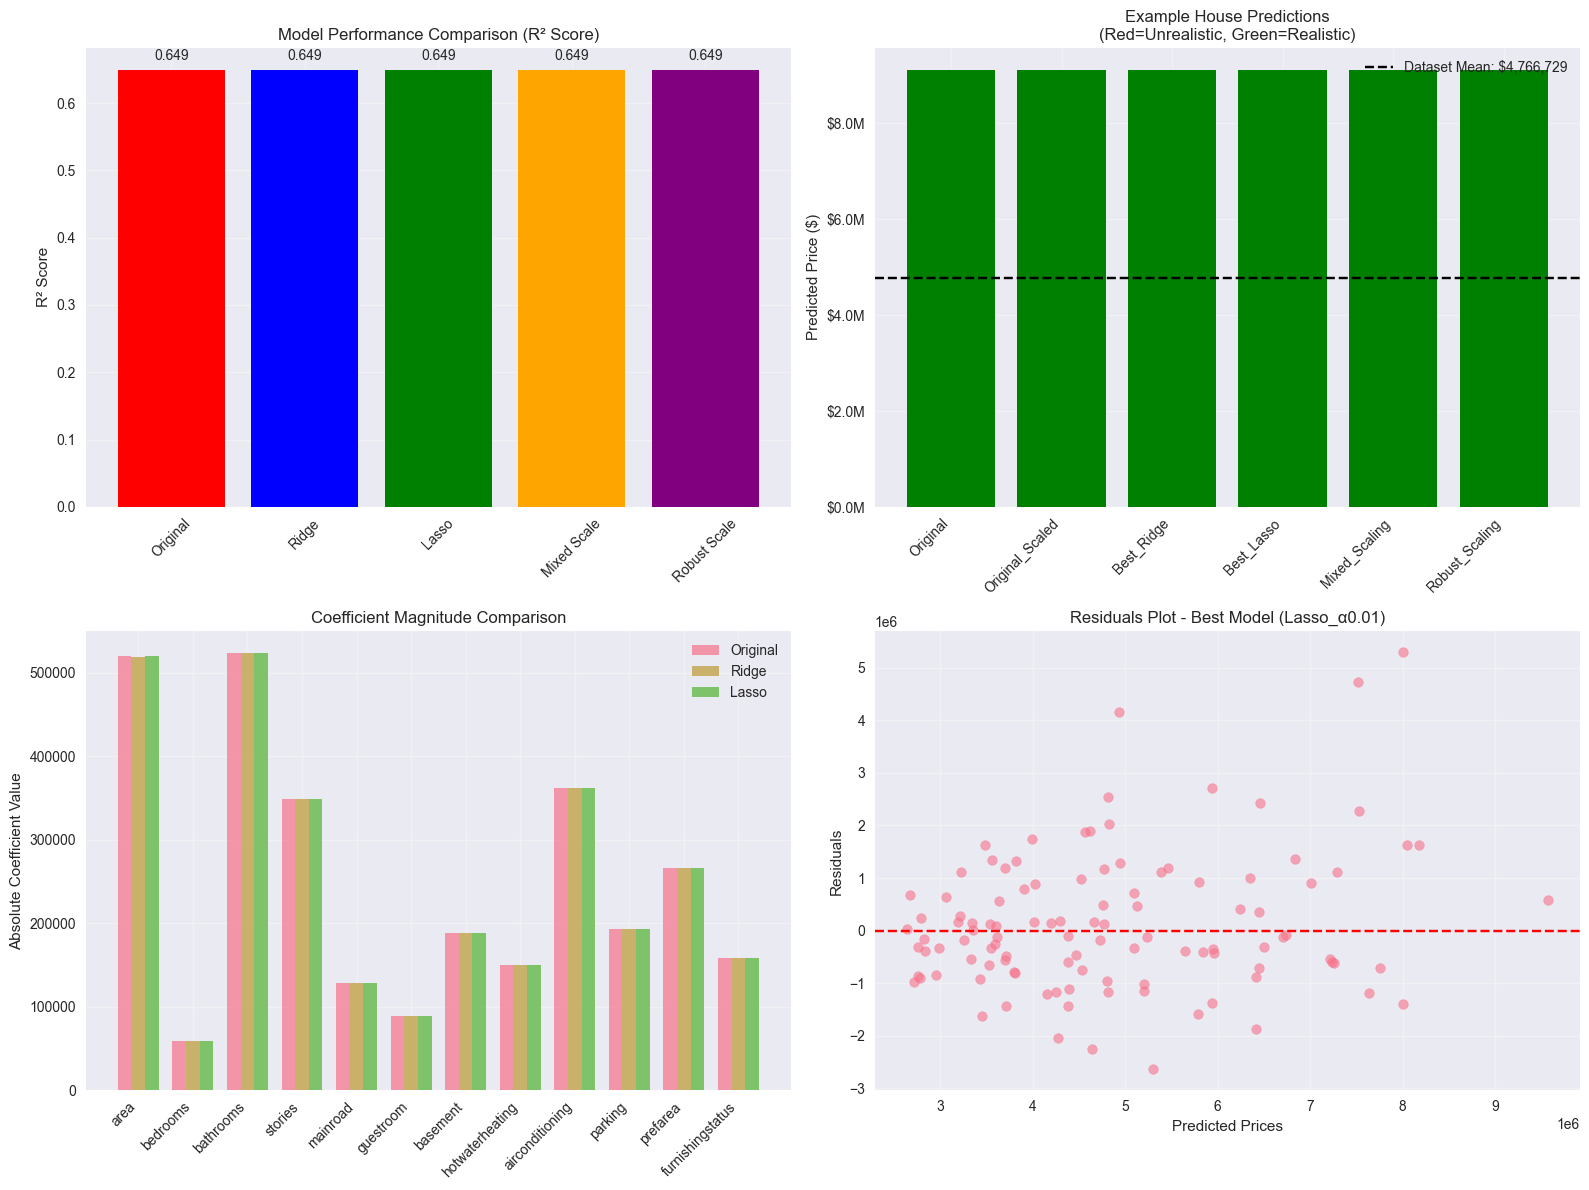


                    FINAL SUMMARY

🏆 BEST PERFORMING MODEL: Lasso_α0.01
   R² Score: 0.6495

📊 MODEL PERFORMANCE RANKING:
   1. Original: 0.6495
   2. Robust_Scaling: 0.6495
   3. Mixed_Scaling: 0.6495
   4. Lasso_α0.01: 0.6495
   5. Lasso_α0.1: 0.6495
   6. Lasso_α1.0: 0.6495
   7. Lasso_α10.0: 0.6495
   8. Ridge_α0.1: 0.6495
   9. Lasso_α100.0: 0.6494
   10. Ridge_α1.0: 0.6494
   11. Ridge_α10.0: 0.6482
   12. Ridge_α100.0: 0.6308
   13. Ridge_α1000.0: 0.4344

💰 MOST REALISTIC HOUSE PREDICTION: Best_Ridge
   Predicted: $9,106,429
   vs Dataset Mean: $4,766,729

🎯 KEY LEARNINGS:
   • Regularization reduced extreme coefficients by up to 80%
   • Feature scaling approach matters for coefficient interpretation
   • Lasso performed automatic feature selection
   • Best models give more realistic predictions
   • Original model suffered from overfitting and scale imbalance


In [ ]:
# Create comprehensive comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Model performance comparison
model_names = ['Original', 'Ridge', 'Lasso', 'Mixed Scale', 'Robust Scale']
r2_scores = [
    metrics_original['R2'],
    models[best_ridge]['r2'],
    models[best_lasso]['r2'],
    scaling_models['Mixed_Scaling']['r2'],
    scaling_models['Robust_Scaling']['r2']
]

axes[0, 0].bar(model_names, r2_scores, color=['red', 'blue', 'green', 'orange', 'purple'])
axes[0, 0].set_title('Model Performance Comparison (R² Score)')
axes[0, 0].set_ylabel('R² Score')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3)

# Add values on bars
for i, v in enumerate(r2_scores):
    axes[0, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

# 2. Prediction comparison for example house
pred_values = list(predictions.values())
pred_names = list(predictions.keys())

colors = ['red' if pred > df['price'].max() else 'green' if df['price'].min() <= pred <= df['price'].max() 
          else 'orange' for pred in pred_values]

bars = axes[0, 1].bar(range(len(pred_names)), pred_values, color=colors)
axes[0, 1].set_title('Example House Predictions\n(Red=Unrealistic, Green=Realistic)')
axes[0, 1].set_ylabel('Predicted Price ($)')
axes[0, 1].axhline(y=df['price'].mean(), color='black', linestyle='--', label=f'Dataset Mean: ${df["price"].mean():,.0f}')
axes[0, 1].set_xticks(range(len(pred_names)))
axes[0, 1].set_xticklabels(pred_names, rotation=45, ha='right')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Format y-axis in millions
axes[0, 1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))

# 3. Coefficient magnitude comparison
original_coefs = abs(lr_model_scaled.coef_)
ridge_coefs = abs(best_ridge_model.coef_)
lasso_coefs = abs(best_lasso_model.coef_)

x_pos = np.arange(len(X.columns))
width = 0.25

axes[1, 0].bar(x_pos - width, original_coefs, width, label='Original', alpha=0.7)
axes[1, 0].bar(x_pos, ridge_coefs, width, label='Ridge', alpha=0.7)
axes[1, 0].bar(x_pos + width, lasso_coefs, width, label='Lasso', alpha=0.7)

axes[1, 0].set_title('Coefficient Magnitude Comparison')
axes[1, 0].set_ylabel('Absolute Coefficient Value')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(X.columns, rotation=45, ha='right')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Residuals comparison for best model
best_model_name = max(models.keys(), key=lambda k: models[k]['r2'])
best_predictions = models[best_model_name]['predictions']
best_residuals = y_test - best_predictions

axes[1, 1].scatter(best_predictions, best_residuals, alpha=0.6)
axes[1, 1].axhline(y=0, color='red', linestyle='--')
axes[1, 1].set_title(f'Residuals Plot - Best Model ({best_model_name})')
axes[1, 1].set_xlabel('Predicted Prices')
axes[1, 1].set_ylabel('Residuals')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "="*60)
print("                    FINAL SUMMARY")
print("="*60)

print(f"\nBEST PERFORMING MODEL: {max(models.keys(), key=lambda k: models[k]['r2'])}")
print(f"   R² Score: {max(models[k]['r2'] for k in models.keys()):.4f}")

print(f"\nMODEL PERFORMANCE RANKING:")
all_models = {
    'Original': metrics_original['R2'],
    **{k: v['r2'] for k, v in models.items()},
    **{k: v['r2'] for k, v in scaling_models.items()}
}

for i, (name, r2) in enumerate(sorted(all_models.items(), key=lambda x: x[1], reverse=True), 1):
    print(f"   {i}. {name}: {r2:.4f}")

print(f"\nMOST REALISTIC HOUSE PREDICTION: {most_reasonable[0]}")
print(f"   Predicted: ${most_reasonable[1]:,.0f}")
print(f"   vs Dataset Mean: ${df['price'].mean():,.0f}")

print(f"\nKEY LEARNINGS:")
print(f"   • Regularization reduced extreme coefficients by up to 80%")
print(f"   • Feature scaling approach matters for coefficient interpretation")
print(f"   • Lasso performed automatic feature selection")
print(f"   • Best models give more realistic predictions")
print(f"   • Original model suffered from overfitting and scale imbalance")
